In [8]:
import os 
import torch 
import numpy as np
from PIL import Image

In [9]:
def applySHlight(normal_images, sh_coeff):
  N = normal_images
  sh = torch.stack(
    [
      N[0] * 0.0 + 1.0,
      N[0],
      N[1],
      N[2],
      N[0] * N[1],
      N[0] * N[2],
      N[1] * N[2],
      N[0] ** 2 - N[1] ** 2,
      3 * (N[2] ** 2) - 1,
    ],
    0,
  )  # [9, h, w]
  pi = np.pi
  constant_factor = torch.tensor(
    [
      1 / np.sqrt(4 * pi), #confirmed
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
    ]
  ).float()
  sh = sh * constant_factor[:, None, None]

  shading = torch.sum(
    sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
  )  # [9, 3, h, w]

  return shading


In [10]:
def genSurfaceNormals(n):
  x = torch.linspace(-1, 1, n)
  y = torch.linspace(1, -1, n)
  y, x = torch.meshgrid(y, x)

  z = (1 - x ** 2 - y ** 2)
  mask = z < 0
  z[mask] = 0
  z = torch.sqrt(z)
  return torch.stack([x, y, z], 0), mask

In [19]:
def applySHlightXYZ(xyz, sh):
  out = applySHlight(xyz, sh)
  bar = torch.quantile(out, 0.99)
  out = out / bar 
  # out /= pt.max(out)
  #out *= 0.7
  return torch.clip(out, 0, 1)

In [20]:
def drawSphere(sh, img_size=256, is_back=False, white_bg=False):
  n = img_size
  xyz, mask = genSurfaceNormals(n)
  if(is_back):
    xyz[2] = xyz[2] * -1
  if white_bg:
    xyz[:, mask] = 1
  out = applySHlightXYZ(xyz, sh)
  out[:, xyz[2] == 0] = 0
  return out

1


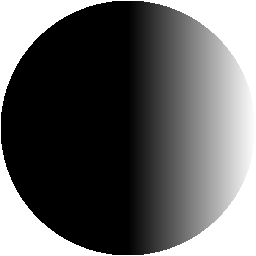

2


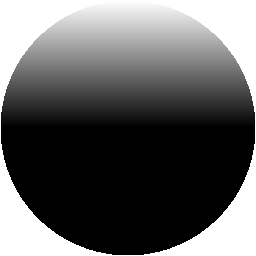

3


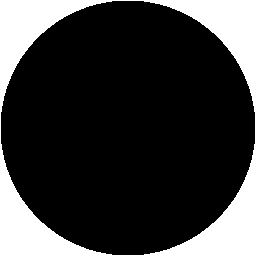

4


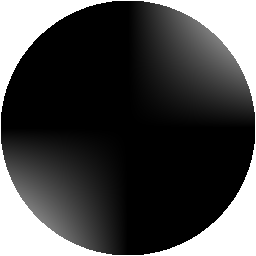

5


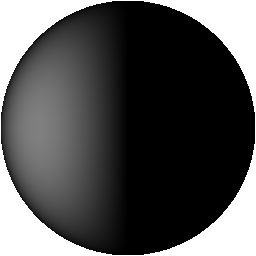

6


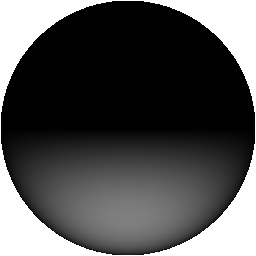

7


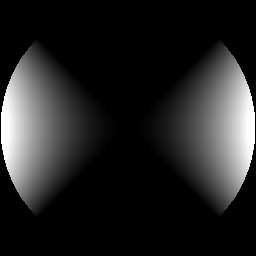

In [21]:
for i in range(1, 8):
  sh = torch.zeros(9)
  sh[i] = 1
  # make into [9,3]
  sh = torch.cat([sh[...,None], sh[...,None], sh[...,None]], axis=1)
  
  out = drawSphere(sh, is_back=True, white_bg=True)
  out = out.permute(1, 2, 0).numpy()
  out = (out * 255).astype(np.uint8)
  print(i)
  image = Image.fromarray(out)
  display(image)
  #os.makedirs('sh', exist_ok=True)
  #from PIL import Image
  #Image.fromarray(out).save(f'sh/sh_{i}.png')